## 🎯 What You Will Learn
###✅ How to access satellite data using STAC APIs with python

###✅ How to retrieve and filter Sentinel-2 and Landsat 8/9 imagery  
###✅ How to apply cloud masking and spatial clipping to an AOI  
###✅ How to compute vegetation and water stress indices (NDVI, NMDI, LST)  
###✅ Derive TVDI (Temperature Vegetation Dryness Index)  
###✅ Generate irrigation decision maps from satellite-derived indicators

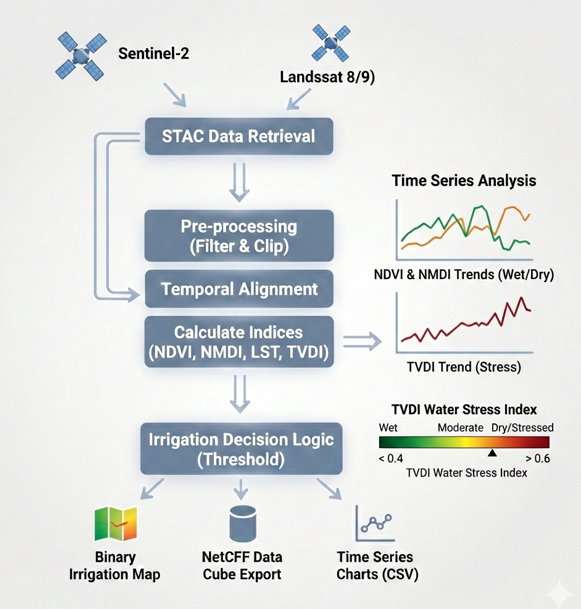

In [ ]:
# Install libraries
!pip install -q pystac-client odc-stac rioxarray netCDF4 planetary_computer

In [ ]:
# Import necessary libraries

import pystac_client
import odc.stac
import planetary_computer as pc

import pandas as pd
import geopandas as gpd
import rioxarray  as rxr
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

import netCDF4
import warnings
import os

# Configure Xarray for better display and performance
xr.set_options(keep_attrs=True, display_expand_data=False)
# Configure NumPy display for cleaner output
np.set_printoptions(threshold=10, edgeitems=2)
# Configure matplotlib for better plots
plt.rcParams["figure.dpi"] = 150

warnings.filterwarnings("ignore");

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Define your save folder directory
GEE_Exports= '/content/drive/MyDrive/GEE_Exports/'

# Create the directory if it doesn't exist
if not os.path.exists(GEE_Exports):
    os.makedirs(GEE_Exports)
    print(f"Created new directory: {GEE_Exports}")
else:
    print(f"Directory already exists: {GEE_Exports}")

In [ ]:
# Load AOI from GeoJSON:

# file Inputs
geojason_file = '/content/drive/MyDrive/Nour_projects_2026/WEST_WEST_Minya_Water_Stress_2026/WEST_Minya.geojson'

# Load the AOI GeoJSON file into a GeoDataFrame
aoi_gdf = gpd.read_file(geojason_file)

# # Ensure correct CRS for searching (4326) and processing (32636)
bbox = aoi_gdf.to_crs("EPSG:4326").total_bounds
aoi_utm = aoi_gdf.to_crs("EPSG:32636")

print(f'Number of pivots polygons : {len(aoi_gdf)}')
aoi_gdf.head()

In [ ]:
# Plot the bounding box using aoi_gdf
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the individual pivots
aoi_gdf.plot(ax=ax, color='green', alpha=0.5)
plt.title("AOI")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

In [ ]:
# Time range
time_range= "2024-09-01/2025-05-01"

In [ ]:
#Connecting to Microsoft Planetary Computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier= pc.sign_inplace,
)

**SENTINEL-2 (OPTICAL)**

In [ ]:
# Sentinel-2 Search
search_s2 = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=time_range,
    query={'eo:cloud_cover': {'lt': 10},}
)

# check the items from sentinel-2 search results
items_s2 = list(search_s2.get_items())
if len(items_s2) == 0:
  raise ValueError ('No Sentinel-2 scenes found')

print (f'Number of Sentinel-2 scenes found: {len(items_s2)}')

In [ ]:
# load search_s2 into xarray
s2_bands = ["B02","B03","B04","B08","B11","B12","SCL"]
ds_s2 = odc.stac.load(
    items_s2,
    bbox = bbox ,
    bands=s2_bands,
    crs = 'EPSG:32636',
    resolution=10,
    groupby= 'solar_day',
    chunks={"x": 256, "y": 256}
)

ds_s2

In [ ]:
# Mask NoData (0) across all bands
# This converts 0 to NaN so they are ignored in math/stats
ds_s2 = ds_s2.where(ds_s2 != 0)

# Sentinel-2 Cloud Mask using SCL (Scene Classification Layer)
# Keep: 4 (Vegetation), 5 (Bare Soils), 6 (Water), 7 (Unclassified)
mask_s2 = ds_s2.SCL.isin([4, 5, 6, 7])
ds_s2 = ds_s2.where(mask_s2)

In [ ]:
# Scale reflectance
s2_clean = ds_s2.drop_vars("SCL").astype("float32") * 0.0001
s2_clean

In [ ]:
#  ---- Calculate Optical Indices ----

# ----------NDVI-------------
# Normalized Difference Vegetation Index  (NDVI) for Vegetation Health
ndvi = (s2_clean.B08 - s2_clean.B04) / (s2_clean.B08 + s2_clean.B04)

# ---------- NMDI-----------
# Normalized multi-band drought index (NMDI) for Moisture Stress - utilizing SWIR difference
# Formula: (NIR - (SWIR1 - SWIR2)) / (NIR + (SWIR1 - SWIR2))
swir_diff = s2_clean.B11 - s2_clean.B12
nmdi = (s2_clean.B08 - swir_diff) / (s2_clean.B08 + swir_diff)

**LANDSAT 8/9 (THERMAL)**

In [ ]:
# Landsat 8/9 Search
search_landsat = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=time_range,
    query={
         "platform": {"in": ["landsat-8", "landsat-9"]},   #select landsat-8 and 9
        'eo:cloud_cover': {'lt': 10},
    }
)

# check the items from sentinel-2 search results
items_landsat = list(search_landsat.get_items())
if len(items_landsat) == 0:
  raise ValueError ('No Landsat scenes found')

print (f'Number of Landsat scenes found: {len(items_landsat)}')

In [ ]:
# Load Landsat into xarray and reproject to match Sentinel-2 grid
landsat_bands = ["lwir11", "qa_pixel"]

# use the geobox from ds_s2 to ensure alignment,

ds_landsat = odc.stac.load(
    items_landsat,
    geobox=ds_s2.odc.geobox,
    bands= landsat_bands,
    groupby='solar_day',
    chunks={"x": 256, "y": 256}
)



In [ ]:
# Landsat Cloud Mask
qa = ds_landsat.qa_pixel
cloud = (qa & (1 << 3)) == 0
shadow = (qa & (1 << 4)) == 0
ds_landsat = ds_landsat.where(cloud & shadow)


In [ ]:
# Mask the zeros (NoData) so they become NaN
lwir_masked = ds_landsat.lwir11.where(ds_landsat.lwir11 != 0)

# Scale ONLY the masked data
# Formula: DN * 0.00341802 + 149.0 - 273.15
lst_c = (lwir_masked.astype("float32") * 0.00341802 + 149.0) - 273.15

In [ ]:
# Check the min and max temp (c)
print(lst_c.min().compute())
print(lst_c.max().compute())

In [ ]:
# Grid alignment (reproject LST (30m) to match NDVI (10m))
lst_aligned = lst_c.rio.reproject_match(s2_clean, resampling=2)# Resampling to 10m; Bilinear used to maintain spectral integrity and spatial continuity

# Verify the CRS attribute
print(f"CRS of lst_aligned: {lst_aligned.rio.crs}")

In [ ]:
lst_aligned

**WEEKLY AGGREGATION**

In [ ]:
# Weekly composites
ndvi_weekly = ndvi.resample(time="1W").median()
nmdi_weekly = nmdi.resample(time="1W").median()
lst_weekly = lst_aligned.resample(time="1W").median()


In [ ]:
#  Temperature Vegetation Dryness Index (TVDI)
def calculate_tvdi(lst_layer):
    lst_min = lst_layer.min(dim=["x","y"])
    lst_max = lst_layer.max(dim=["x","y"])
    tvdi = (lst_layer - lst_min) / (lst_max - lst_min)
    return tvdi.clip(0,1)

tvdi_weekly = calculate_tvdi(lst_weekly)

tvdi_weekly

**FINAL DATASET + CLIP**

In [ ]:
# Merging Datasets
final_ds = xr.merge([ndvi_weekly.to_dataset(name='ndvi'),
                     nmdi_weekly.to_dataset(name='nmdi'),
                     lst_weekly.to_dataset(name='lst'),
                     tvdi_weekly.to_dataset(name='tvdi')],
                    compat='override')

final_ds = final_ds.rio.write_crs("EPSG:32636")
final_ds

In [ ]:
# Clip final dataset
final_ds_clipped = final_ds.rio.clip(
    aoi_utm.geometry,
    aoi_utm.crs,
    drop=True
)

**AOI TIME SERIES (ALL INDICES)**

In [ ]:
# Compute AOI mean
aoi_ts = (final_ds_clipped.mean(dim=["x","y"])
         .chunk({'time': -1})     # Rechunk 'time' dimension into a single chunk
         .interpolate_na(dim="time", method="linear").compute()  # Apply interpolation to fill the missing values based on the values before and after.
         .to_dataframe()
         )
aoi_ts.reset_index(inplace=True)

aoi_ts.to_csv("aoi_weekly_timeseries.csv", index=False)

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(10,8), sharex=True)

# Vegetation panel
axes[0].plot(aoi_ts.time, aoi_ts.ndvi, label="NDVI")
axes[0].plot(aoi_ts.time, aoi_ts.nmdi, label="NMDI")
axes[0].set_ylabel("Vegetation Indices")
axes[0].legend()
axes[0].set_title("AOI Weekly Vegetation Condition")

# Stress panel
axes[1].plot(aoi_ts.time, aoi_ts.tvdi, label="TVDI")
axes[1].axhline(0.6, linestyle="--")
axes[1].set_ylabel("Water Stress")
axes[1].set_title("AOI Weekly Water Stress")
axes[1].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the figure:
# plt.savefig(save_path + "Time Series Plot.png", dpi=300)    # uncomment to save the figure


**RGB VALIDATION MAP**

In [ ]:
# select a target date
selected_date = "2025-04-01"


In [ ]:
# select date for final_ds_clipped data
selected = final_ds_clipped.sel(time=selected_date, method="nearest")

# RGB map
rgb = s2_clean[["B04","B03","B02"]]  # select RGB bands
rgb_selected = rgb.sel(time=selected_date, method="nearest")      # at selected date
# Transpose rearranges the axes to make (y) first, the width (x) second, and the color info (variable\Bands) last
rgb_selected.to_array().transpose("y","x","variable").plot.imshow(robust=True)

plt.title(f"RGB - {selected_date}")
plt.axis("off")
plt.show()

# Save the figure:
# plt.savefig(save_path + "RGB.png", dpi=300)    # uncomment to save the figure

In [ ]:
# NDVI at selected date
plt.figure(figsize=(6,3))
selected.ndvi.plot(cmap="YlGn", vmin=-0.6, vmax=0.8)
plt.title(f"NDVI - {str(selected.time.values)[:10]}")
plt.axis("off")
plt.show()

# Save the figure:
# plt.savefig(save_path + "NDVI.png", dpi=300)    # uncomment to save the figure

In [ ]:
# LST_C
plt.figure(figsize=(6,3))
selected.lst.plot(cmap="hot_r" , vmin=10, vmax=60)
plt.title(f"LST (°C) - {str(selected.time.values)[:10]}")
plt.axis("off")
plt.show()

# Save the figure:
# plt.savefig(save_path + "LST (°C).png", dpi=300)    # uncomment to save the figure

**TVDI VALIDATION PLOT AND MAP**

In [1]:
# # TVDI Triangle Validation: NDVI-LST Feature Space Analysis

# select the date
ds_date = final_ds.sel(time=selected_date, method="nearest")

# 2. Flatten and clean NaNs
n = ds_date.ndvi.values.flatten()
l = ds_date.lst.values.flatten()
mask = ~np.isnan(n) & ~np.isnan(l)

# 3. Sample 10,000 points (to keep the plot fast and responsive)
df = pd.DataFrame({'NDVI': n[mask], 'LST': l[mask]})
df_sample = df.sample(n=min(10000, len(df)))

# 4. Create the Interactive Plot
fig = px.scatter(
    df_sample,
    x="NDVI",
    y="LST",
    color="LST",           # Color points by temperature
    color_continuous_scale="Viridis",
    title=f"Interactive Feature Space - Minya ({selected_date})",
    labels={"LST": "Temperature (°C)", "NDVI": "NDVI"},
    template="plotly_white",
    opacity=0.5            # Transparency helps see density
)

# Fix axis ranges
fig.update_xaxes(range=[0, 1])
fig.show()

In [ ]:
# TVDI Map
plt.figure(figsize=(6,3))
selected.tvdi.plot(
    cmap="RdYlBu_r",
    vmin=0,
    vmax=1,
    cbar_kwargs={"label":"Water Stress (0=Wet, 1=Dry)"}
)
plt.title(f"Water Stress (TVDI) - {str(selected.time.values)[:10]}")
plt.axis("off")
plt.show()

# Save the figure:
# plt.savefig(save_path + "Water Stress (TVDI).png", dpi=300)   # uncomment to save the figure

**Binary Irrigation Decision Map**

In [ ]:
def classify_stress_binary(tvdi, threshold=0.6):
    """
    Returns 1 for Irrigation Needed, 0 for Safe.
    """
    return (tvdi > threshold).astype(int)      # use.astype(int) converts True/False to 1/0

# apply it
final_ds_clipped["need_irrigation"] = classify_stress_binary(final_ds_clipped.tvdi)

final_ds_clipped

In [ ]:
# check the irrigation need at the the selected date
ds_date = final_ds_clipped.sel(time=selected_date, method="nearest")

# plot Binary Irrigation Decision Map
plt.figure(figsize=(7,4))
ds_date.need_irrigation.plot(
    cmap="Reds",
    vmin=0,
    vmax=1,
    cbar_kwargs={"label":"Irrigation Needed (0=No, 1=Yes)"}
)
plt.title(f"Irrigation Decision Map - {selected_date}")
plt.axis("off")
plt.show()

# Save the figure:
# plt.savefig(save_path + "Irrigation Decision Map.png", dpi=300)  # uncomment to save the figure

**EXPORT TO DRIVE**

In [ ]:
# Save Stats Summary (Percentage of farm area needing irrigation)
stats = final_ds_clipped.mean(dim=["x", "y"]).compute().to_dataframe()
stats.to_csv(os.path.join(GEE_Exports, "stats_summary.csv"))

# Save the full processed DataCube (NetCDF)
final_ds_clipped.to_netcdf(os.path.join(GEE_Exports, "full_data_cube.nc"))

# Export 34-week series as a single Multiband GeoTIFF
final_ds_clipped.need_irrigation.rio.to_raster(os.path.join(GEE_Exports, "irrigation_time_series_stack.tif"))

# Export Band Metadata (Dates per band )
dates_df = pd.DataFrame({
    'band_number': range(1, len(final_ds_clipped.time) + 1),
    'date': pd.to_datetime(final_ds_clipped.time.values).strftime('%Y-%m-%d')
})

dates_df.to_csv(os.path.join(GEE_Exports, "band_metadata_dates.csv"), index=False)

print(f"All files exported successfully to: {GEE_Exports}")